In [25]:
from models.recognition.model import OCRModel
from models.recognition.dataset import OCRVietnamese, ClusterRandomSampler
from models.recognition.train import train_model
from models.recognition.utils import process_image
from models.recognition.vocab import Vocabulary
from models.recognition.loss import LabelSmoothingLoss

# from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch
import os

from configs.recognition_config import d_model, d_ff, num_heads, num_decoder_layers, dropout, maxlen

In [26]:
vocab = Vocabulary(maxlen=maxlen)
len(vocab)

232

In [27]:
from PIL import Image

In [28]:
root = './datasets/img/'
train = []
with open(root + 'annotation_train.txt', 'r') as f:
    annotations = [l.strip().split("\t") for l in f.readlines()] 
    for image_path, text in annotations:
        train.append({
            'image_path': root+image_path,
            'text': text
        })
        
val = []
with open(root + 'annotation_val_small.txt', 'r') as f:
    valid = [l.strip().split("\t") for l in f.readlines()] 
    for image_path, text in annotations:
        val.append({
            'image_path': root+image_path,
            'text': text
        })

len(train), len(val)

(5483, 5483)

In [29]:
batch_size = 32

# test_len = int(len(annotations)*0.01) #% test
# train, test = torch.utils.data.random_split(annotations, [len(annotations)-test_len, test_len])

train_dataset = OCRVietnamese(train, vocab, process_image, maxlen)
train_sampler = ClusterRandomSampler(train_dataset, batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_dataset = OCRVietnamese(val, vocab, process_image, maxlen)
val_sampler = ClusterRandomSampler(val_dataset, batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)

  0%|          | 0/5483 [00:00<?, ?it/s]

  0%|          | 0/5483 [00:00<?, ?it/s]

In [30]:
model = OCRModel(
    vocab_size=len(vocab),
    d_model = d_model,
    num_heads = num_heads,
    d_ff = d_ff,
    num_decoder_layers = num_decoder_layers,
    dropout = dropout
)

optimizer = AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-09)
criterion = LabelSmoothingLoss(classes=len(vocab), padding_idx=vocab.char2idx['<pad>'], smoothing=0.1)

In [31]:
epochs = 200
continue_train = True

In [ ]:
model_name = f'model_weights-{epochs}'
if os.path.exists(f'./checkpoints/recognition/{model_name}.pth'):
    state_dict = torch.load(f'./checkpoints/recognition/{model_name}.pth')
    model.load_state_dict(state_dict)
    print('weights loaded')
    
if continue_train:
    train_model(model, train_loader, optimizer, criterion, vocab, epochs) # đang train với test_loader
    torch.save(model.state_dict(), f'./checkpoints/recognition/{model_name}.pth')

In [ ]:
# from models.recognition.eval import evaluate
# device = 'cpu'
# model.to(device)
# avg_loss, acc = evaluate(model, test_loader, criterion, device, vocab)

# infer

actual:  châu Úc với Trung Đông. Giao lưu quốc tế thuận lợi, phát triển ngành biển.
generated:  châu Úc với Trung Đông. Giao lưu quốc tế thuận lợi, phát triển ngành biển.


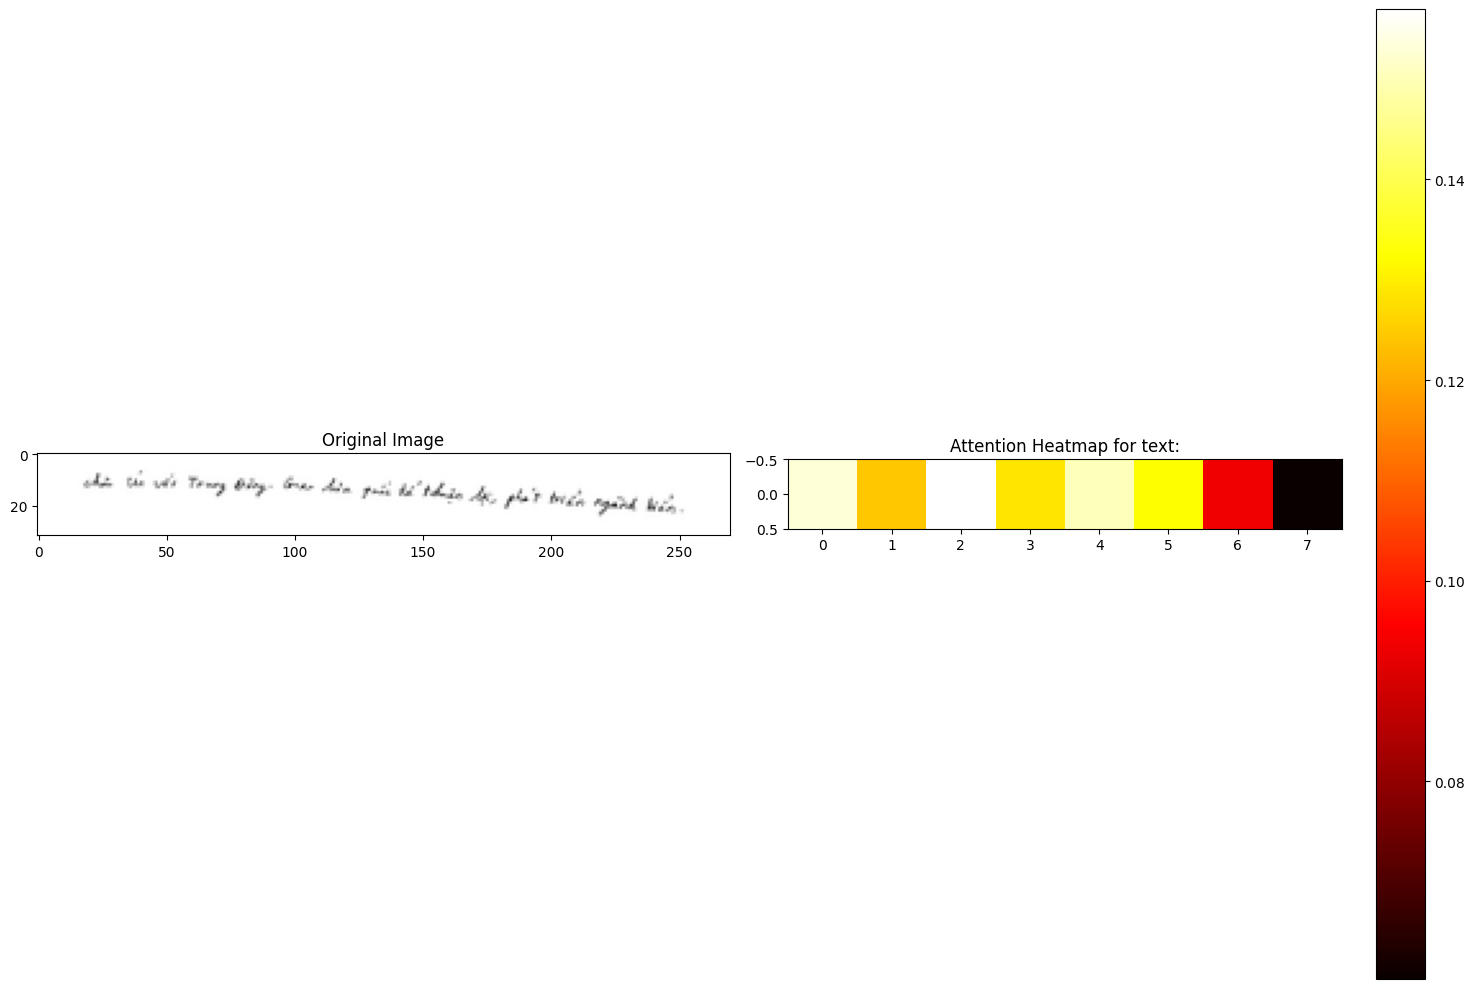

In [35]:
img, txt, path = val_dataset.get_random_image()

model = model.to('mps')
image = img.to('mps')

pred_txt, f ,a  = model.generate_text(image.unsqueeze(0), vocab)
model.visualize_attention(img, txt, pred_txt[0], f, a)